Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.decomposition import PCA


Data loading

In [2]:
df = pd.read_csv('Heart_disease_cleveland_new.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,0,145,233,1,2,150,0,2.3,2,0,2,0
1,67,1,3,160,286,0,2,108,1,1.5,1,3,1,1
2,67,1,3,120,229,0,2,129,1,2.6,1,2,3,1
3,37,1,2,130,250,0,0,187,0,3.5,2,0,1,0
4,41,0,1,130,204,0,2,172,0,1.4,0,0,1,0


Data exploration


In [3]:
print('--- Data Info ---')
df.info()
print('\n--- Missing Values ---')
print(df.isnull().sum())
print("--- Duplicate Rows ---")
print(df.duplicated().sum())


--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB

--- Missing Values ---
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal     

In [4]:
print("\n--- Categorical Features ---")
expected_values = {
       'sex': [0, 1],
       'cp': [0, 1, 2, 3],
       'fbs': [0, 1],
       'restecg': [0, 1, 2],
       'exang': [0, 1],
       'slope': [0, 1, 2],
       'ca': [0, 1, 2, 3, 4],
       'thal': [1, 2, 3],
       'target': [0, 1]
   }

for feature, expected in expected_values.items():
       if feature in df.columns:
           unique_vals = sorted(df[feature].unique())
           print(f"{feature}: unique values in data = {unique_vals}, expected = {expected}")
           if set(unique_vals) != set(expected):
               print(f"  WARNING: Unexpected value(s) in {feature}!\n")
       else:
           print(f"{feature}: NOT FOUND in DataFrame columns!\n")
print('\n--- Basic Statistics ---')
display(df.describe(include='all'))


--- Categorical Features ---
sex: unique values in data = [np.int64(0), np.int64(1)], expected = [0, 1]
cp: unique values in data = [np.int64(0), np.int64(1), np.int64(2), np.int64(3)], expected = [0, 1, 2, 3]
fbs: unique values in data = [np.int64(0), np.int64(1)], expected = [0, 1]
restecg: unique values in data = [np.int64(0), np.int64(1), np.int64(2)], expected = [0, 1, 2]
exang: unique values in data = [np.int64(0), np.int64(1)], expected = [0, 1]
slope: unique values in data = [np.int64(0), np.int64(1), np.int64(2)], expected = [0, 1, 2]
ca: unique values in data = [np.int64(0), np.int64(1), np.int64(2), np.int64(3)], expected = [0, 1, 2, 3, 4]

thal: unique values in data = [np.int64(1), np.int64(2), np.int64(3)], expected = [1, 2, 3]
target: unique values in data = [np.int64(0), np.int64(1)], expected = [0, 1]

--- Basic Statistics ---


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,0.679868,2.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,0.600660,0.663366,1.831683,0.458746
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.934375,0.956705,0.499120
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,48.000000,0.000000,2.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,56.000000,1.000000,2.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,1.000000,0.000000
75%,61.000000,1.000000,3.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,1.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,3.000000,3.000000,1.000000


Normalisation

In [5]:
features_to_scale = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
scaler = StandardScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,0.948726,1,0,0.757525,-0.264900,1,2,0.017197,0,1.087338,2,0,2,0
1,1.392002,1,3,1.611220,0.760415,0,2,-1.821905,1,0.397182,1,3,1,1
2,1.392002,1,3,-0.665300,-0.342283,0,2,-0.902354,1,1.346147,1,2,3,1
3,-1.932564,1,2,-0.096170,0.063974,0,0,1.637359,0,2.122573,2,0,1,0
4,-1.489288,0,1,-0.096170,-0.825922,0,2,0.980537,0,0.310912,0,0,1,0


Separate features and target and Data split

In [7]:
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

Training set size: 242 samples
Test set size: 61 samples


Logistic Regression with Stratified K-Fold Cross-Validation 

In [8]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
f1 = make_scorer(f1_score)
scores = cross_val_score(logreg, X_train, y_train, cv=skf, scoring=f1)
print(f"F1-scores for each fold: {scores}")
print(f"Mean F1-score: {scores.mean():.3f}")

F1-scores for each fold: [0.85106383 0.76923077 0.7804878  0.7826087  0.8372093 ]
Mean F1-score: 0.804


Logistic Regression Hyperparameter

In [9]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l2'],              # L2 regularization (default and recommended)
    'solver': ['lbfgs'],            # 'lbfgs' works well for small to medium datasets
    'class_weight': ['balanced']
}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
logreg = LogisticRegression(max_iter=1000, random_state=42)
grid_search = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    scoring='f1',
    cv=skf,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best cross-validated F1-score: {:.3f}".format(grid_search.best_score_))

Best parameters: {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}
Best cross-validated F1-score: 0.805


Logistic Regression evaluation on Test Data

Test F1-score: 0.867
Test Accuracy: 0.869

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.82      0.87        33
           1       0.81      0.93      0.87        28

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.88      0.87      0.87        61



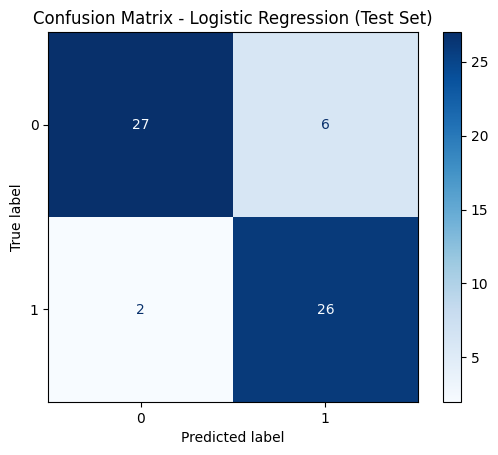

In [10]:
best_logreg = grid_search.best_estimator_
y_pred = best_logreg.predict(X_test)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print(f"Test F1-score: {f1:.3f}")
print(f"Test Accuracy: {accuracy:.3f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_logreg.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Logistic Regression (Test Set)")
plt.show()

In [11]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
f1 = make_scorer(f1_score)
scores = cross_val_score(logreg, X_train, y_train, cv=skf, scoring=f1)
print(f"F1-scores for each fold: {scores}")
print(f"Mean F1-score: {scores.mean():.3f}")

F1-scores for each fold: [0.85106383 0.76923077 0.7804878  0.7826087  0.8372093 ]
Mean F1-score: 0.804


Random Forest with Stratified K-Fold Cross-Validation

In [12]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
f1 = make_scorer(f1_score)
rf_scores = cross_val_score(rf, X_train, y_train, cv=skf, scoring=f1)
print(f"F1-scores for each fold: {rf_scores}")
print(f"Mean F1-score: {rf_scores.mean():.3f}")

F1-scores for each fold: [0.82352941 0.76923077 0.73170732 0.81818182 0.73170732]
Mean F1-score: 0.775


Random Forest Hyperparameters

In [13]:
param_grid_rf = {
    'n_estimators': [100, 200, 300],         
    'max_depth': [None, 5, 10, 20],          
    'min_samples_split': [2, 5, 10],         
    'min_samples_leaf': [1, 2, 4],           
    'class_weight': ['balanced']             
}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    scoring='f1',
    cv=skf,
    n_jobs=-1
)
grid_search_rf.fit(X_train, y_train)
print("Best parameters for Random Forest:", grid_search_rf.best_params_)
print("Best cross-validated F1-score for Random Forest: {:.3f}".format(grid_search_rf.best_score_))

Best parameters for Random Forest: {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validated F1-score for Random Forest: 0.798


Random Forest evealuation on Test Data

Test F1-score (Random Forest): 0.881
Test Accuracy (Random Forest): 0.885

Classification Report (Random Forest):
               precision    recall  f1-score   support

           0       0.93      0.85      0.89        33
           1       0.84      0.93      0.88        28

    accuracy                           0.89        61
   macro avg       0.89      0.89      0.89        61
weighted avg       0.89      0.89      0.89        61



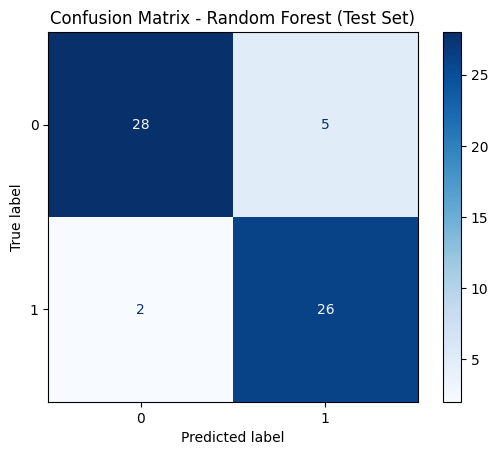

In [14]:
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
f1_rf = f1_score(y_test, y_pred_rf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
cm_rf = confusion_matrix(y_test, y_pred_rf)
print(f"Test F1-score (Random Forest): {f1_rf:.3f}")
print(f"Test Accuracy (Random Forest): {accuracy_rf:.3f}")
print("\nClassification Report (Random Forest):\n", classification_report(y_test, y_pred_rf))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=best_rf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Random Forest (Test Set)")
plt.show()

SVM with Stratified K-fold Cross-Validation

In [15]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
svm = SVC(class_weight='balanced', kernel='rbf', random_state=42)
f1 = make_scorer(f1_score)
svm_scores = cross_val_score(svm, X_train, y_train, cv=skf, scoring=f1)
print(f"F1-scores for each fold: {svm_scores}")
print(f"Mean F1-score: {svm_scores.mean():.3f}")

F1-scores for each fold: [0.89361702 0.73684211 0.8        0.8        0.82608696]
Mean F1-score: 0.811


SVM Hyperparameters

In [16]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],  
    'class_weight': ['balanced']
}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
svm = SVC(random_state=42)
grid_search_svm = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    scoring='f1',
    cv=skf,
    n_jobs=-1
)
grid_search_svm.fit(X_train, y_train)
print("Best parameters for SVM:", grid_search_svm.best_params_)
print("Best cross-validated F1-score for SVM: {:.3f}".format(grid_search_svm.best_score_))

Best parameters for SVM: {'C': 1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validated F1-score for SVM: 0.811


SVM with Test Data

Test F1-score (SVM): 0.833
Test Accuracy (SVM): 0.836

Classification Report (SVM):
               precision    recall  f1-score   support

           0       0.90      0.79      0.84        33
           1       0.78      0.89      0.83        28

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61



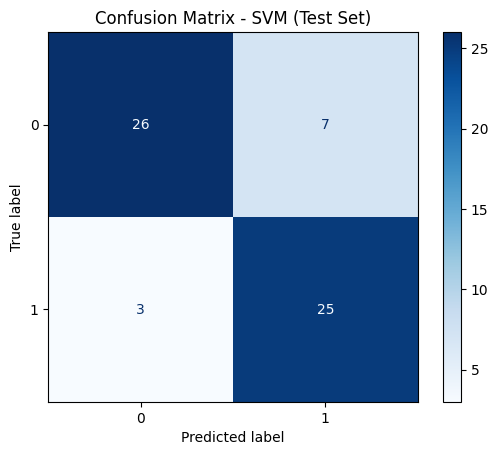

In [17]:
best_svm = grid_search_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test)
f1_svm = f1_score(y_test, y_pred_svm)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
cm_svm = confusion_matrix(y_test, y_pred_svm)

print(f"Test F1-score (SVM): {f1_svm:.3f}")
print(f"Test Accuracy (SVM): {accuracy_svm:.3f}")
print("\nClassification Report (SVM):\n", classification_report(y_test, y_pred_svm))

disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=best_svm.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - SVM (Test Set)")
plt.show()

Explanation of choices:

I experimented with several supervised classification models: Logistic Regression, Random Forest, and Support Vector Machine (SVM).

I tried models with different characteristics: 

Logistic Regression is a strong baseline for binary classification and provides interpretable coefficients.
Random Forest is robust to outliers, can capture non-linear relationships, and is less sensitive to feature scaling.
SVM is effective for high-dimensional data and can model complex boundaries with the right kernel.

The choise of paprameters:

For Logistic Regression, I tuned the regularization strength C over a wide range (0.01 to 100) to balance underfitting and overfitting.

For Random Forest, I tuned n_estimators (number of trees), max_depth, min_samples_split, and min_samples_leaf to control model complexity and prevent overfitting.

For SVM, I tuned C (regularization), kernel (linear and RBF), and gamma (for RBF) to find the best margin and boundary for the data.

For all models I used class_weight='balanced' to address class imbalance. 


The best parameters were selected based on cross-validated F1-score.




ROC curves

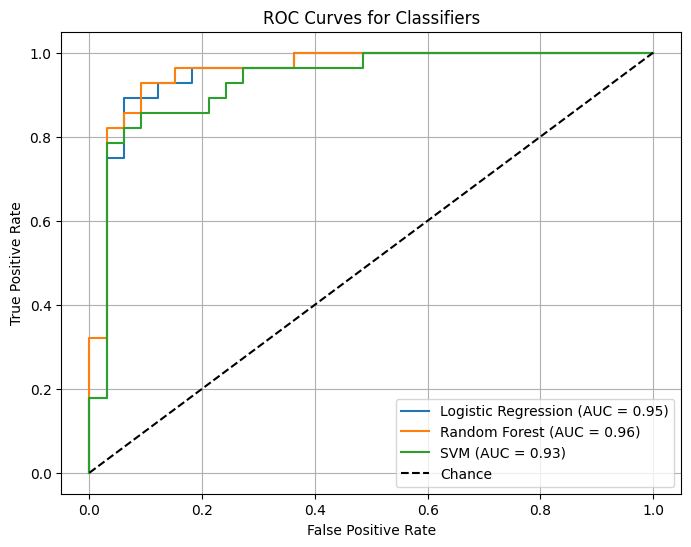

In [18]:
plt.figure(figsize=(8, 6))

y_score_logreg = best_logreg.predict_proba(X_test)[:, 1]
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_score_logreg)
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)
plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic Regression (AUC = {roc_auc_logreg:.2f})')

y_score_rf = best_rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_score_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')

if hasattr(best_svm, "predict_proba"):
    y_score_svm = best_svm.predict_proba(X_test)[:, 1]
else:
    y_score_svm = best_svm.decision_function(X_test)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_score_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_auc_svm:.2f})')


plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Classifiers')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Logistic Regression with PCA

In [19]:
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"Original number of features: {X_train.shape[1]}")
print(f"Reduced number of PCA components: {X_train_pca.shape[1]}")

Original number of features: 13
Reduced number of PCA components: 10


Test F1-score (LogReg + PCA): 0.847
Test Accuracy (LogReg + PCA): 0.852

Classification Report (LogReg + PCA):
               precision    recall  f1-score   support

           0       0.90      0.82      0.86        33
           1       0.81      0.89      0.85        28

    accuracy                           0.85        61
   macro avg       0.85      0.86      0.85        61
weighted avg       0.86      0.85      0.85        61



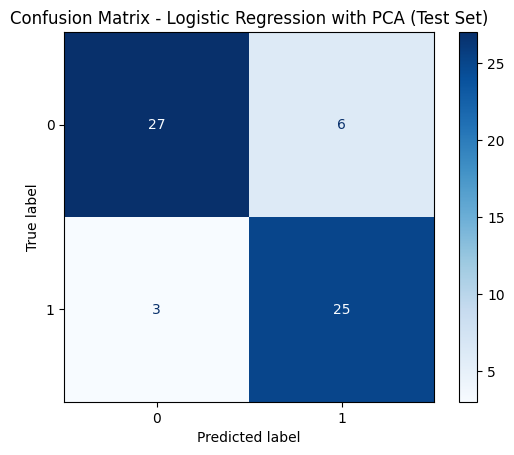

In [20]:
logreg_pca = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
logreg_pca.fit(X_train_pca, y_train)
y_pred_pca = logreg_pca.predict(X_test_pca)
f1_pca = f1_score(y_test, y_pred_pca)
accuracy_pca = accuracy_score(y_test, y_pred_pca)
cm_pca = confusion_matrix(y_test, y_pred_pca)
print(f"Test F1-score (LogReg + PCA): {f1_pca:.3f}")
print(f"Test Accuracy (LogReg + PCA): {accuracy_pca:.3f}")
print("\nClassification Report (LogReg + PCA):\n", classification_report(y_test, y_pred_pca))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_pca, display_labels=logreg_pca.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Logistic Regression with PCA (Test Set)")
plt.show()

TRP and FRP vs. Threshold (Logistic Regression)

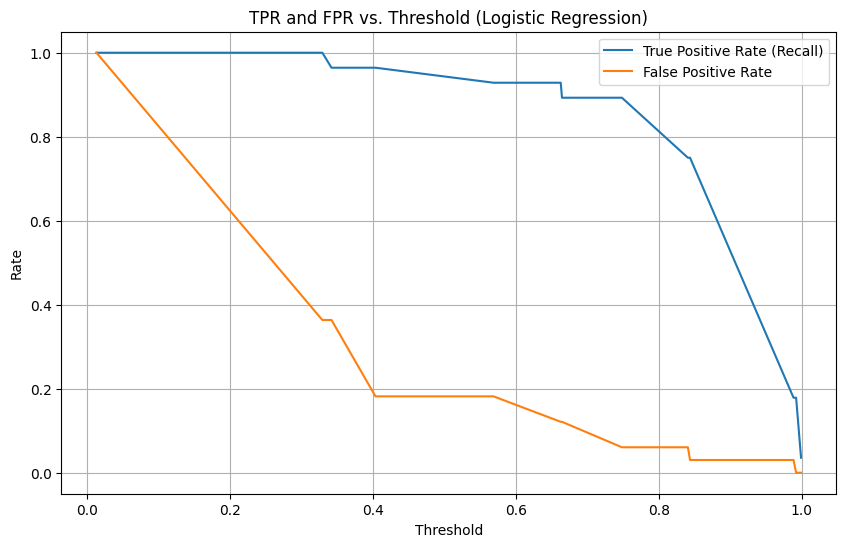

In [21]:
y_scores = best_logreg.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_scores)

plt.figure(figsize=(10, 6))

plt.plot(thresholds, tpr, label='True Positive Rate (Recall)')
plt.plot(thresholds, fpr, label='False Positive Rate')
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.title('TPR and FPR vs. Threshold (Logistic Regression)')
plt.legend()
plt.grid(True)
plt.show()